# Tutorial 4: Testing spatial generalization
**Week 2, Day 5: AI and Climate Change**

**By Climatematch Academy**

__Content creators:__  Deepak Mewada, Grace Lindsay

__Content reviewers:__ Name Surname, Name Surname

__Content editors:__ Name Surname, Name Surname

__Production editors:__ Name Surname, Name Surname

___

# Tutorial Objectives

*Estimated timing of tutorial: 20 minutes

In this tutorial we will:   
* Learn the concept of within distribution generalization
* Test your model’s ability on a certain type of out-of-distribution data





In [ ]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today


## Uncomment the code below to test your function

#from IPython.display import IFrame
#link_id = "<YOUR_LINK_ID_HERE>"

print("If you want to download the slides: 'Link to the slides'")
      # Example: https://osf.io/download/{link_id}/

#IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)



---
# **Setup**

In [ ]:
# @title Import necessary libraries:

import matplotlib.pyplot as plt    # For plotting graphs
import pandas as pd                 # For data manipulation

# # Import specific machine learning models and tools
from sklearn.model_selection import train_test_split      # For splitting dataset into train and test sets
from sklearn.ensemble import RandomForestRegressor        # For Random Forest Regression
from sklearn.tree import DecisionTreeRegressor            # For Decision Tree Regression

<details>
<summary> <font color='Red'>Click here if you are running on local machine or you encounter any error while importing   </font></summary>
Please note that if you are running this code on a local machine and encounter an error while importing a library, make sure to install the library via pip. For example, if you receive a `ModuleNotFoundError: No module named 'library name` error , please run `pip install 'library name` to install the required module.

In [ ]:
# @title Helper functions { display-mode: "form" }

# If any helper functions you want to hide for clarity (that has been seen before
# or is simple/uniformative), add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell

# Load and Prepare the Data
url_Climatebench_train_val = "https://osf.io/y2pq7/download"  # Dataset URL
training_data = pd.read_csv(url_Climatebench_train_val)  # Load the training data from the provided URL
training_data.pop('scenario')  # Drop the 'scenario' column as it's just a label and won't be passed into the model
target = training_data.pop('tas_FINAL')  # Extract the target variable 'tas_FINAL' which we aim to predict

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(training_data, target, test_size=0.2, random_state=1)

In [ ]:
# @title Set random seed { display-mode: "form" }

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# E.g., for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import numpy as np

def set_seed(seed=None):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  print(f'Random seed {seed} has been set.')


set_seed(seed=2024)  # change 2023 with any number you like
# Set a global seed value for reproducibility
random_state = 42

In [ ]:
# @title Plotting functions { run: "auto", display-mode: "form" }
#@markdown Run this cell to define plotting function we will be using in this code

def visualize_decision_tree(X_train, y_train, X_test, y_test, dt_model):
    # Plot decision tree and regression
    plt.figure(figsize=(10, 5))

    # Plot Decision Tree
    plt.subplot(1, 2, 1)
    plt.scatter(X_train, y_train, color='blue', label='Training data')
    plt.scatter(X_test, y_test, color='green', label='Test data')
    plt.plot(np.sort(X_test, axis=0), dt_model.predict(np.sort(X_test, axis=0)), color='red', label='Model')
    plt.title('Decision Tree Regression')
    plt.xlabel('Feature')
    plt.ylabel('Target')
    plt.legend()

    # Plot Decision Tree
    plt.subplot(1, 2, 2)
    plot_tree(dt_model, filled=True)
    plt.title("Decision Tree")

    plt.tight_layout()
    plt.show()

def visualize_random_forest(X_train, y_train, X_test, y_test, rf_model):
    num_trees = len(rf_model.estimators_)
    num_cols = min(3, num_trees)
    num_rows = (num_trees + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 6 * num_rows))

    # Plot Random Forest Regression
    plt.subplot(num_rows, num_cols, 1)
    plt.scatter(X_train, y_train, color='blue', label='Training data')
    plt.scatter(X_test, y_test, color='green', label='Test data')
    plt.plot(np.sort(X_test, axis=0), rf_model.predict(np.sort(X_test, axis=0)), color='red', label='Model')
    plt.title('Random Forest Regression')
    plt.xlabel('Feature')
    plt.ylabel('Target')
    plt.legend()

    # Plot Decision Trees within Random Forest
    for i, tree in enumerate(rf_model.estimators_):
        plt.subplot(num_rows, num_cols, i + 2)
        plot_tree(tree, filled=True)
        plt.title(f"Tree {i+1}")

    plt.tight_layout()
    plt.show()


---
# **Section 1:  Test generalization to held-out spatial locations**
---



In [ ]:
# @title Video 1: Video 1 Name
from ipywidgets import widgets
from IPython.display import display, IFrame, YouTubeVideo

out2 = widgets.Output()
with out2:
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print(f'Video available at https://www.bilibili.com/video/{video.id}')
  display(video)

out1 = widgets.Output()
with out1:
  video = YouTubeVideo(id="", width=854, height=480, fs=1, rel=0)
  print(f'Video available at https://youtube.com/watch?v={video.id}')
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

In the video we discussed how we previously tested generalization to unseen data points from the same data distribution (i.e., same region and scenarios)  
Now we will see if the model generalizes to data from a new region.



## Section 1.1: Load the New Testing Data

We will take our random forest model that was trained on data from the region in the blue box and see if it can work well using lat/lon locations that come from the red box. We already have the data from the blue box region loaded, so now we just need to load the data from the red box.

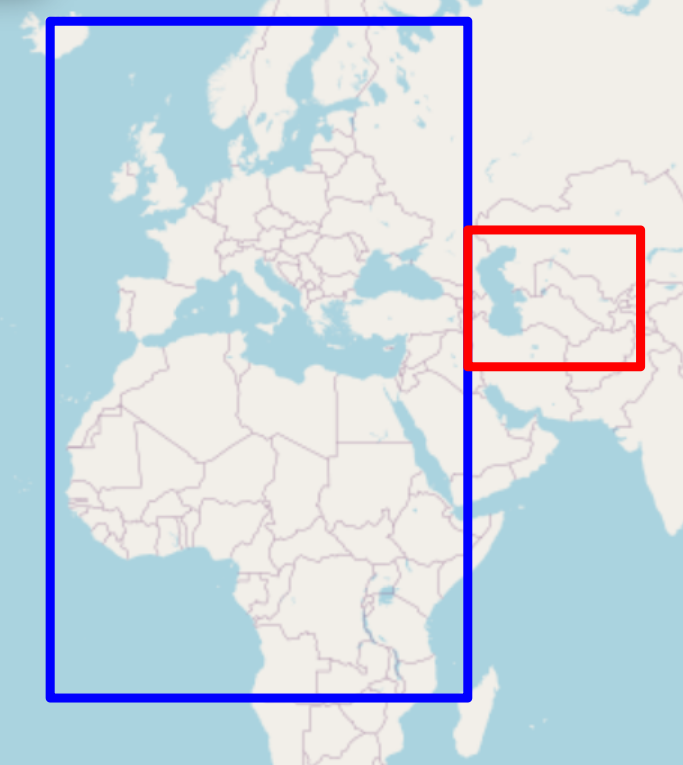

In [ ]:
# @title Loading the new Spatial test data

url_spatial_test_data = "https://osf.io/7tr49/download" # location of test data
spatial_test_data = pd.read_csv(url_spatial_test_data)  # Load spatial test data from the provided URL
spatial_test_data.pop('scenario')  #we will drop the `scenario` column from the data as it is just a label, but will not be passed into the model.
spatial_test_target = spatial_test_data.pop('tas_FINAL')  # Extract the target variable 'tas_FINAL'
# Display the prepared spatial test data
spatial_test_data


If we plot the temperature distribution over space, we can see that this dataset has a different range of latitude and longitude values than the initial dataset.  

In [ ]:
# Plot spatial distribution of temperature
col_name = 'tas_2015'
plt.figure(figsize=(10, 6))
plt.scatter(spatial_test_data['lon'], spatial_test_data['lat'], c=spatial_test_data[col_name], cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Temperature (T)')
plt.title('Spatial Distribution of Temperature (2015)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

## Section 1.2: Evaluate the model

We've been playing around with the random forest model parameters. To make sure we know what model we are evaluating, let's train it again here on the training data specifically with `n_estimators=80` and `max_depth=50`.

In [ ]:
rf_regressor = RandomForestRegressor(random_state=42,n_estimators=80,max_depth=50)
# Train the model on the training data
rf_regressor.fit(X_train, y_train)
train_score = rf_regressor.score(X_train,y_train)
test_score = rf_regressor.score(X_test,y_test)
print( "Training Set Score     : ", train_score)
print( "   Test  Set Score     : ", test_score)

Now that the model has been trained on data from the blue box region, let's test how well it performs on data from the red box region

In [ ]:
spatial_test_score = rf_regressor.score(spatial_test_data,spatial_test_target)
print( "Spatial Test Data Score : ", spatial_test_score)

Make a scatter plot of the predicted vs true 2050 temperature values for this data, like you did previously.

### Coding Exercise 4.2 : Scatter Plot for Spatial data
In this exercise implement `scatter_plot_predicted_vs_true` function to evaluate the performance of a pre-trained Random Forest regressor model on a new emissions scenario and create a scatter plot of predicted vs. true temperature values.

In [ ]:
def scatter_plot_predicted_vs_true(spatial_test_data, true_values):
    """Create a scatter plot of predicted vs true temperature values.

    Args:
        spatial_test_data: Test features.
        true_values (ndarray): True temperature values.

    Returns:
        None
    """
     #################################################
    ## TODO for students: Implement scatter plot of predicted vs true temperature values ##
    # Make predictions using the random forest regressor
    # Use plt.scatter() to plot the data points
    # Use plt.plot() to plot the diagonal line y=x
    # Label the x-axis as 'Predicted Temperatures' and y-axis as 'True Temperatures'
        # Fill remove the following line of code once you have completed the exercise:
    raise NotImplementedError("Student exercise: Implement the scatter plot of predicted vs true temperature values.")
    #################################################

    # Make predictions using the random forest regressor
    #spatial_test_predicted = #TODO

    spatial_test_score = rf_regressor.score(spatial_test_data, true_values)
    print("Spatial Test Data Score:", spatial_test_score)

    # Implement scatter plot of predicted vs true temperature values
    #plt.scatter(...., true_values, color='b') #TODO

    plt.plot([min(spatial_test_predicted), max(spatial_test_predicted)], [min(true_values), max(true_values)], color='r')
    plt.xlabel('Predicted Temperatures')
    plt.ylabel('True Temperatures')
    plt.show()

# Remove the comment to run this code
#scatter_plot_predicted_vs_true(spatial_test_data,spatial_test_target)

In [ ]:
# to_remove solution

def scatter_plot_predicted_vs_true(spatial_test_data, true_values):
    """Create a scatter plot of predicted vs true temperature values.

    Args:
        spatial_test_data: Test features.
        true_values (ndarray): True temperature values.

    Returns:
        None
    """
    #################################################
    ## TODO for students: Implement scatter plot of predicted vs true temperature values ##
    # Use plt.scatter() to plot the data points
    # Use plt.plot() to plot the diagonal line y=x
    # Label the x-axis as 'Predicted Temperatures' and y-axis as 'True Temperatures'
    #################################################

    # Make predictions using the random forest regressor
    spatial_test_predicted = rf_regressor.predict(spatial_test_data)

    spatial_test_score = rf_regressor.score(spatial_test_data, true_values)
    print("Spatial Test Data Score:", spatial_test_score)

    # Implement scatter plot of predicted vs true temperature values
    plt.scatter(spatial_test_predicted, true_values, color='b')
    plt.plot([min(spatial_test_predicted), max(spatial_test_predicted)], [min(true_values), max(true_values)], color='r')
    plt.xlabel('Predicted Temperatures')
    plt.ylabel('True Temperatures')
    plt.show()

# Remove the comment to run this code
scatter_plot_predicted_vs_true(spatial_test_data,spatial_test_target)

### Think! : Performance of the model for new spatial location data

1. Have you observed the decrease in score?   
2. What do you believe could be the cause of this?   
3. What do you think would happen if the model was tested on an even farther away region, for example, in North America?

In [ ]:
#to_remove_explanation

"""
1. Yes, there appears to be a decrease in score when the model is tested on new location data.
2. The decrease in score could be attributed to the model's inability to generalize well to new locations.
 It's possible that the model has learned patterns specific to the training data but fails to capture the nuances present in the new location data.
3. If the model was tested on an even farther away region, such as North America,
 we might expect the performance to deteriorate further. This is because the model was trained on data from a different geographical region,
 and it may struggle to accurately predict temperatures in regions with vastly different climate patterns and environmental factors.
"""



---


# **Summary**



In this tutorial, we investigated the generalization capacity of machine learning models to novel geographical regions. The process involved assessing model performance on spatial datasets from diverse locations, shedding light on the model's adaptability across varying environmental contexts.

---






---


                                Congratulations! You have reached the end of the  tutorial.   



---
